In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gsw 

# pip install bottleneck
# pip install tqdm

from tqdm.notebook import tqdm
from scipy.interpolate import interp1d

In [2]:
ds=xr.open_dataset('L0-timeseries/wam_sbus_1230_Nov_Dec_Jan.nc', chunks={})  

In [3]:
ds['latitude']=ds.latitude/100
ds['dive_index']= ds.profile_index // 2

In [4]:
def _verify(data):
    plt.figure(figsize=(20,10))

    dives = data.dive_index.values
    dives = np.unique(dives[np.isfinite(dives)])
    dives = np.round(np.percentile(dives,[1,5,10,15,20,25, 30,50]))

    # xlims = np.nanpercentile(data.salinity.values,[1,99])
    xlims = [34.5,35]
    
    for idx in range(len(dives)):
        plt.subplot(2,int(len(dives)/2),idx+1)
        dn = (data.dive_index==dives[idx]) & (data.pressure > 5) & (data.pressure < 250)
        plt.plot(data.salinity[dn],data.temperature[dn],'-r', alpha=0.3)
        # plt.plot(data.salinity_corr[dn],data.temperature_corr[dn],'-b',alpha=0.8)
        
        plt.title('Dive '+str(dives[idx]))
        plt.xlim(xlims)

## Correct thermal lag

In [5]:
t = ds.indexes["time"]
if not t.is_unique:
    ds = ds.isel(time=~t.duplicated())

In [6]:
# plt.hist(ds['pitch'])

C:\Users\estel\AppData\Local\Temp\ipykernel_16324\76285878.py:2: RuntimeWarning: divide by zero encountered in divide
  spd=np.abs( vert_spd / np.sin(ds['pitch'].interpolate_na('time').values))
C:\Users\estel\AppData\Local\Temp\ipykernel_16324\76285878.py:2: RuntimeWarning: invalid value encountered in divide
  spd=np.abs( vert_spd / np.sin(ds['pitch'].interpolate_na('time').values))


Text(0.5, 0, 'speed')

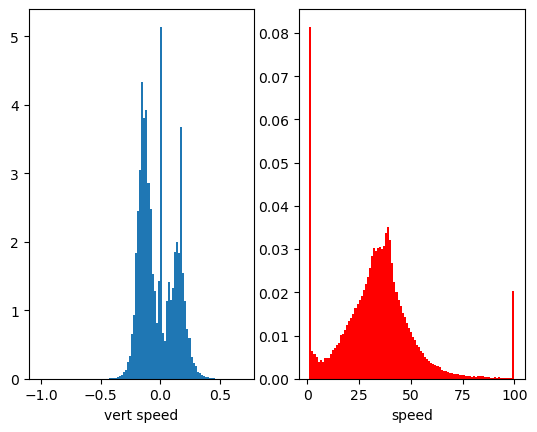

In [7]:
vert_spd=np.gradient( -gsw.z_from_p(ds['pressure'].interpolate_na('time').values,ds['latitude'].interpolate_na('time').values),  ds.time.values.astype('float')) * 1e9
spd=np.abs( vert_spd / np.sin(ds['pitch'].interpolate_na('time').values))
spd[spd < 0.01] = 0.01
spd[spd > 1] = 1
spd[~np.isfinite(spd)] = 0.01
spd = spd*100
plt.subplot(121)
_=plt.hist(vert_spd, bins=100, density=True)
plt.xlabel('vert speed')
plt.subplot(122)
_=plt.hist(spd, bins=100, density=True, color='r')
plt.xlabel('speed')

In [176]:
# ds=ds.drop('depth', 'date_float')

In [36]:
import numpy as np
import pandas as pd
from tqdm import tqdm

import gsw
from scipy.optimize import fmin


# ----------------------------
# Fast 2D binning (no pandas)
# ----------------------------
def _make_2d_binner(x, y, xi=1, yi=0.3):
    """
    Precompute bin edges + a linear bin id per sample.
    This is the expensive part; do it ONCE and reuse in every objective evaluation.
    """
    x = np.asarray(x)
    y = np.asarray(y)

    if np.size(xi) == 1:
        xedges = np.arange(np.nanmin(x), np.nanmax(x) + xi, xi, dtype=float)
    else:
        xedges = np.asarray(xi, dtype=float)

    if np.size(yi) == 1:
        yedges = np.arange(np.nanmin(y), np.nanmax(y) + yi, yi, dtype=float)
    else:
        yedges = np.asarray(yi, dtype=float)

    nx = len(xedges) - 1
    ny = len(yedges) - 1

    # bin index per sample (like pd.cut(labels=False), but much faster)
    xb = np.searchsorted(xedges, x, side="right") - 1
    yb = np.searchsorted(yedges, y, side="right") - 1

    valid = (
        np.isfinite(x) & np.isfinite(y) &
        (xb >= 0) & (xb < nx) &
        (yb >= 0) & (yb < ny)
    )

    xb = xb[valid].astype(np.int64)
    yb = yb[valid].astype(np.int64)

    # Flatten 2D bin indices to 1D bin id
    lin = xb + nx * yb  # shape: (n_valid,)

    return xedges, yedges, nx, ny, valid, lin


def _bin2d_mean(v, nx, ny, valid, lin):
    """
    Fast binned mean for v over (x,y) bins, using precomputed 'valid' and 'lin'.
    Returns array with shape (ny, nx) to match your old grid2d layout.
    """
    vv = np.asarray(v)[valid]
    good = np.isfinite(vv)
    vv = vv[good]
    lin2 = lin[good]

    nbin = nx * ny
    s = np.bincount(lin2, weights=vv, minlength=nbin)
    c = np.bincount(lin2, minlength=nbin)

    out = np.full(nbin, np.nan, dtype=float)
    m = c > 0
    out[m] = s[m] / c[m]
    return out.reshape(ny, nx)


# -----------------------------------------
# Fast Morison recursive bias (Numba/Python)
# -----------------------------------------

def get_bias(temp, a, b):
    n = temp.shape[0]
    bias = np.zeros(n, dtype=np.float64)
    for i in range(1, n):
        bias[i] = -b[i] * bias[i - 1] + a[i] * (temp[i] - temp[i - 1])
    return bias


# ----------------------------
# Polygon area utilities
# ----------------------------
def _triangle_area(x1, y1, x2, y2, x3, y3):
    return np.abs(0.5 * (x1 * (y2 - y3) + x2 * (y3 - y1) + x3 * (y1 - y2)))


def _poly_area_triangles_from_grids(S, T):
    """
    Your original triangle-area approach, but taking gridded arrays directly.
    S, T have shape (ny, nprofiles)
    """
    area = 0.0
    nprof = T.shape[1]
    for idx in range(nprof - 1):
        x1 = S[:, idx]
        x2 = S[:, idx + 1]
        y1 = T[:, idx]
        y2 = T[:, idx + 1]

        gd = np.isfinite(x1 + x2 + y1 + y2)
        if not np.any(gd):
            continue

        x1 = x1[gd]
        x2 = x2[gd]
        y1 = y1[gd]
        y2 = y2[gd]

        # replicate your two-triangle construction with nan padding
        area += np.nansum(_triangle_area(
            np.append(x1, np.nan), np.append(y1, np.nan),
            np.append(x2, np.nan), np.append(y2, np.nan),
            np.append(np.nan, x1), np.append(np.nan, y1),
        ))
        area += np.nansum(_triangle_area(
            np.append(np.nan, x1), np.append(np.nan, y1),
            np.append(x2, np.nan), np.append(y2, np.nan),
            np.append(np.nan, x2), np.append(np.nan, y2),
        ))
    return area


# -------------------------------------------
# Main function: faster regression + correction
# -------------------------------------------
def correctSalinityGarau(
    data,
    coefs=None,
    # regression speed knobs:
    n_dives_for_regress=1000,
    max_regress_points=200000,
    # grid resolution for the score:
    xi=1,
    yi=0.3,
    # optimizer knobs:
    maxiter=200,
    ftol=0.01,    
    # progress bar knobs
    regression_progress=True,
    regression_progress_total=None,  # if None, uses heuristic
    # apply full correction?
    # apply full correction?
    apply_full=False,
):
    """
    Notes:
      - Score uses BINNED MEAN instead of median. This is typically fine for regression and much faster.
      - Full correction still can be heavy for 2M points; set apply_full=True only once you have coefs.
    """

    print("Estimating flow speed...")
    # time in ns? your data.time.astype(float) suggests ns timestamps; keep consistent with your code
    time = data["time"].astype(float).values

    # z_from_p needs pressure (dbar) and latitude (deg)
    pres_full = data["pressure"].interpolate_na("time").values
    lat_full = data["latitude"].interpolate_na("time").values
    pitch_full = data["pitch"].interpolate_na("time").values

    z = -gsw.z_from_p(pres_full, lat_full)  # depth positive downward
    # gradient wrt time, then *1e9 because time in ns in your original
    vert_spd = np.gradient(z, time) * 1e9

    flowSpeed = np.abs(vert_spd / np.sin(pitch_full))
    flowSpeed[flowSpeed > 1] = 1
    flowSpeed[flowSpeed < 0.03] = 0.03
    flowSpeed[~np.isfinite(flowSpeed)] = 0.03

    temp_full = data["temperature"].values.astype(float)
    cond_full = data["conductivity"].values.astype(float)*10

    # Sampling frequency estimate (your original)
    print("Performing thermal mass correction...")
    Fs = np.mean(1.0 / np.gradient(time / 1e9))
    print(f"         Assuming a sampling frequency of {Fs} Hz.")

    fn = Fs / 2.0  # Nyquist

    # Precompute these for speed (used in alpha/tau)
    inv_flow = 1.0 / flowSpeed
    inv_sqrt_flow = 1.0 / np.sqrt(flowSpeed)

    def _calcSal(temp, cond, pres, coefs_local, inv_flow_local, inv_sqrt_flow_local):
        a_offset, a_slope, t_offset, t_slope = coefs_local

        alpha = a_offset + a_slope * inv_flow_local
        tau = t_offset + t_slope * inv_sqrt_flow_local

        alpha[~np.isfinite(alpha)] = a_offset
        tau[~np.isfinite(tau)] = t_offset

        # Lueck & Picklo style params (as in your code)
        a = 4.0 * fn * alpha * tau / (1.0 + 4.0 * fn * tau)
        b = 1.0 - 2.0 * a / alpha

        # ensure float64 for numba
        temp64 = np.asarray(temp, dtype=np.float64)
        a64 = np.asarray(a, dtype=np.float64)
        b64 = np.asarray(b, dtype=np.float64)

        bias = get_bias(temp64, a64, b64)
        # gsw wants cond in mS/cm? your original uses cond*10, keep it
        return gsw.SP_from_C(cond , temp64 + bias, pres), temp64 + bias

    def _regressSal():
        # --- pick a subset of dives (your original idea, slightly cleaned) ---
        d = data["dive_index"].values
        gd_dives = d[np.isfinite(d)]
        if gd_dives.size == 0:
            raise ValueError("No finite dive_index values found for regression.")

        # choose ~n_dives_for_regress evenly across available dives
        # pick = np.unique(np.linspace(0, len(gd_dives) - 1, n_dives_for_regress).astype(int))
        chosen_dives = gd_dives[::]

        mask = (
            np.isin(d, chosen_dives) &
            np.isfinite(temp_full) &
            np.isfinite(cond_full) &
            np.isfinite(data["pressure"].values) &
            (data["pressure"].values > 7) &
            (data["pressure"].values < 250)
        )

        idx = np.flatnonzero(mask)
        if idx.size == 0:
            raise ValueError("Regression mask selected 0 points. Check pressure/temp/cond validity.")

        # --- subsample to max_regress_points ---
        # step = max(1, idx.size // max_regress_points)
        # idx = idx[::step]

        _temp = temp_full[idx]
        _cond = cond_full[idx]
        _pres = data["pressure"].values.astype(float)[idx]
        _inv_flow = inv_flow[idx]
        _inv_sqrt_flow = inv_sqrt_flow[idx]

        # We will grid in x=profile_index, y=pressure (same as your code)
        x = data["profile_index"].values.astype(float)[idx]
        y = _pres

        # Precompute grid mapping ONCE
        xedges, yedges, nx, ny, valid_xy, lin = _make_2d_binner(x, y, xi=xi, yi=yi)

        # Grid temperature ONCE (mean) for the polygon computation
        Tgrid = _bin2d_mean(_temp, nx, ny, valid_xy, lin).T  # make it (ny,nx)-> then transpose? Wait:
        # _bin2d_mean returns (ny, nx) where x is columns, y is rows.
        # Your old grid2d returned grid shape [len(yi), len(xi)] = (ny, nx).
        # And later you indexed T[:, idx] where columns are profiles.
        # So we want grid with shape (ny, nprofiles) => (ny, nx).
        # So NO transpose needed:
        Tgrid = _bin2d_mean(_temp, nx, ny, valid_xy, lin)

        # Scaling (your original)

        scaler = np.array([0.0135, 0.0264, 7.1499, 2.7858], dtype=float)

        # progress bar over objective evaluations
        pbar = None
        eval_counter = {"n": 0}
        if regression_progress:
            total = regression_progress_total
            if total is None:
                # heuristic: NM often uses a few evals per iteration
                total = int(maxiter * 6)
            pbar = tqdm(total=total, desc="Regressing coefficients (evals)", leave=True)

        def _scoreFunction(x_vals):
            eval_counter["n"] += 1
            if pbar is not None:
                # update if within declared total; otherwise keep updating anyway
                if pbar.n < pbar.total:
                    pbar.update(1)
                else:
                    pbar.total += 1
                    pbar.update(1)

            co = np.asarray(x_vals, dtype=float) * scaler
            S = _calcSal(_temp, _cond, _pres, co, _inv_flow, _inv_sqrt_flow)[0]
            Sgrid = _bin2d_mean(S, nx, ny, valid_xy, lin)
            return _poly_area_triangles_from_grids(Sgrid, Tgrid)

        print("Beginning regression...")
        print(f"         Using {idx.size} points for regression.")
        print(f"         Initial score: {_scoreFunction([1, 1, 1, 1])}.")

        R = fmin(
            _scoreFunction,
            [1, 1, 1, 1],
            disp=True,
            full_output=True,
            maxiter=maxiter,
            ftol=ftol,
        )

        if pbar is not None:
            pbar.close()
        print(f"         Final minimisation score: {_scoreFunction(R[0])}.")
        return R[0] * scaler

    if coefs is None:
        coefs = _regressSal()
        print("Regressed coefficients:")
    else:
        coefs = np.asarray(coefs, dtype=float)
        print("Correcting using supplied coefficients:")

    print(coefs)

    if apply_full:
        print("Applying correction to all data (can be slow on 2M points)...")

        # Interpolate temperature because recursion propagates NaNs
        temp_i = data["temperature"].interpolate_na("time").bfill("time").values.astype(float)
        cond_i = data["conductivity"].values.astype(float)*10
        pres_i = data["pressure"].values.astype(float)

        # use full inv_flow arrays
        sal_corr, temp_corr= _calcSal(temp_i, cond_i, pres_i, coefs, inv_flow, inv_sqrt_flow)
        data["salinity_corr"] = sal_corr
        data["temperature_corr"] = temp_corr

        # # optional outlier clipping like your original
        # if "salinity" in data:
        #     bad = ~(np.abs(data["salinity_corr"] - data["salinity"]) < 1)
        #     data.loc[bad, "salinity_corr"] = np.nan

    return data


In [37]:
# <2500 profile we sample up and down!  --- so we do the regression on only this bit!
mask = (ds.profile_index < 2500).compute()
ds_sub = ds.where(mask, drop=True)               ## a couple min!

In [38]:
#get the coeffiecients -- up to 20min
data2 = correctSalinityGarau(ds_sub, coefs=None, apply_full=False)

Estimating flow speed...


C:\Users\estel\AppData\Local\Temp\ipykernel_16324\2231058038.py:168: RuntimeWarning: divide by zero encountered in divide
  flowSpeed = np.abs(vert_spd / np.sin(pitch_full))


Performing thermal mass correction...
         Assuming a sampling frequency of 0.9978240195951505 Hz.


Regressing coefficients (evals):   0%|                                                        | 0/1200 [00:00<?, ?it/s]

Beginning regression...
         Using 919787 points for regression.


Regressing coefficients (evals):   0%|                                                | 2/1200 [00:03<35:05,  1.76s/it]

         Initial score: 997.7071619659372.


Regressing coefficients (evals):  28%|████████████▋                                 | 330/1200 [19:23<51:33,  3.56s/it]C:\Users\estel\AppData\Local\Temp\ipykernel_16324\2231058038.py:292: RuntimeWarning: Maximum number of iterations has been exceeded.
  R = fmin(
Regressing coefficients (evals):  28%|████████████▋                                 | 330/1200 [19:27<51:17,  3.54s/it]


         Final minimisation score: 515.5242528454312.
Regressed coefficients:
[-9.43753272e-03  6.44642962e-04  1.79284519e+01  6.55293381e+00]


In [39]:
# coefs = [-7.27158418e-03,  2.24607932e-04,  2.27891776e+01 , 4.09828533e+00]
coefs = [-9.43753272e-03 , 6.44642962e-04 , 1.79284519e+01 , 6.55293381e+00]

# grab the printed ones, or modify function to return them too -- apply coef to the data and correct salinity and temp
data2 = correctSalinityGarau(ds, coefs=coefs, apply_full=True)

Estimating flow speed...


C:\Users\estel\AppData\Local\Temp\ipykernel_16324\2231058038.py:168: RuntimeWarning: divide by zero encountered in divide
  flowSpeed = np.abs(vert_spd / np.sin(pitch_full))
C:\Users\estel\AppData\Local\Temp\ipykernel_16324\2231058038.py:168: RuntimeWarning: invalid value encountered in divide
  flowSpeed = np.abs(vert_spd / np.sin(pitch_full))


Performing thermal mass correction...
         Assuming a sampling frequency of 0.9983168408528541 Hz.
Correcting using supplied coefficients:
[-9.43753272e-03  6.44642962e-04  1.79284519e+01  6.55293381e+00]
Applying correction to all data (can be slow on 2M points)...


In [40]:
data2["salinity_corr"] = xr.DataArray(data2['salinity_corr'].values, dims=("time",), coords={"time": data2["time"]})
data2["temperature_corr"] = xr.DataArray(data2['temperature_corr'].values, dims=("time",), coords={"time": data2["time"]})


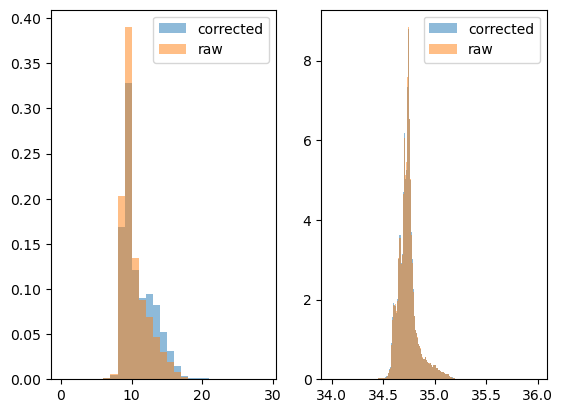

In [41]:
plt.subplot(121)
_=plt.hist(data2['temperature_corr'].values, density=True, alpha=0.5, bins=np.arange(0,30,1), label='corrected')
_=plt.hist(data2['temperature'].values, density=True, alpha=0.5, bins=np.arange(0,30,1), label='raw')
plt.legend()

plt.subplot(122)
_=plt.hist(data2['salinity_corr'].values, density=True, alpha=0.5,bins=np.arange(34,36, 0.01), label='corrected')
_=plt.hist(data2['salinity'].values, density=True, alpha=0.5, bins=np.arange(34,36, 0.01), label='raw')
plt.legend()


In [33]:
np.nanmean(data2['salinity'].values), np.nanmean(data2['salinity_corr'].values)

(np.float64(34.743060403423556), np.float64(34.74257483962758))

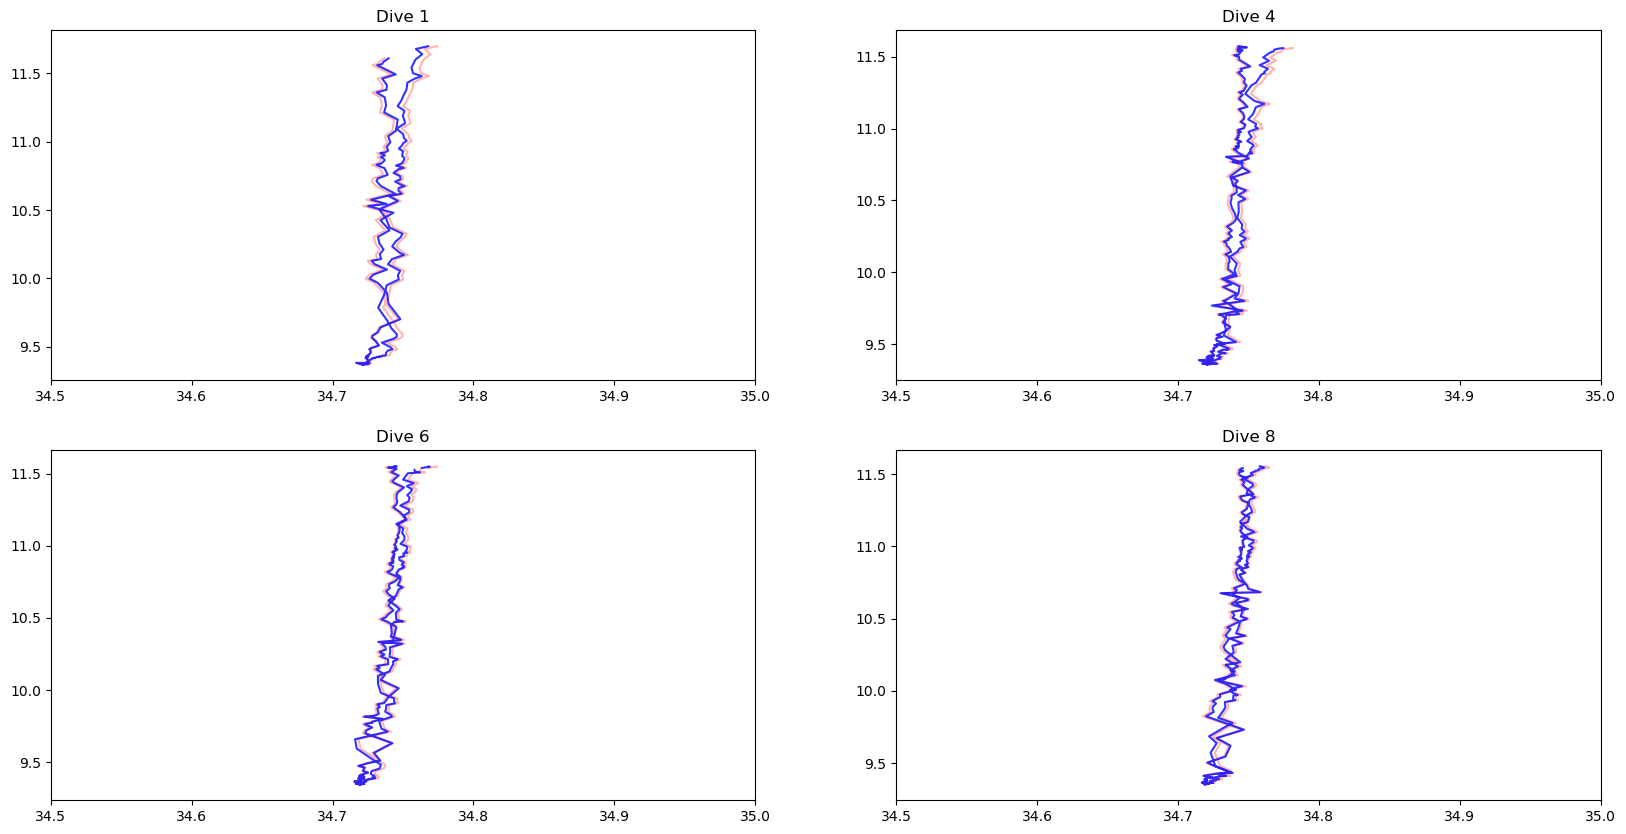

In [21]:
def _verify(data):
    plt.figure(figsize=(20,10))

    dives = data.dive_index.values
    dives = np.unique(dives[np.isfinite(dives)])
    dives = [1,4, 6,8]

    # xlims = np.nanpercentile(data.salinity.values,[1,99])
    xlims = [34.5,35]
    
    for idx in range(len(dives)):
        plt.subplot(2,int(len(dives)/2),idx+1)
        dn = ((data.dive_index == dives[idx]) &
              (data.pressure > 10) &
              (data.pressure < 200)).compute()

        plt.plot(data.salinity.where(dn, drop=True).values,
                 data.temperature.where(dn, drop=True).values, '-r', alpha=0.3)
        
        plt.plot(data.salinity_corr.where(dn, drop=True).values,
                 data.temperature.where(dn, drop=True).values, '-b', alpha=0.8)

        plt.title('Dive '+str(dives[idx]))
        plt.xlim(xlims)

_verify(data2)

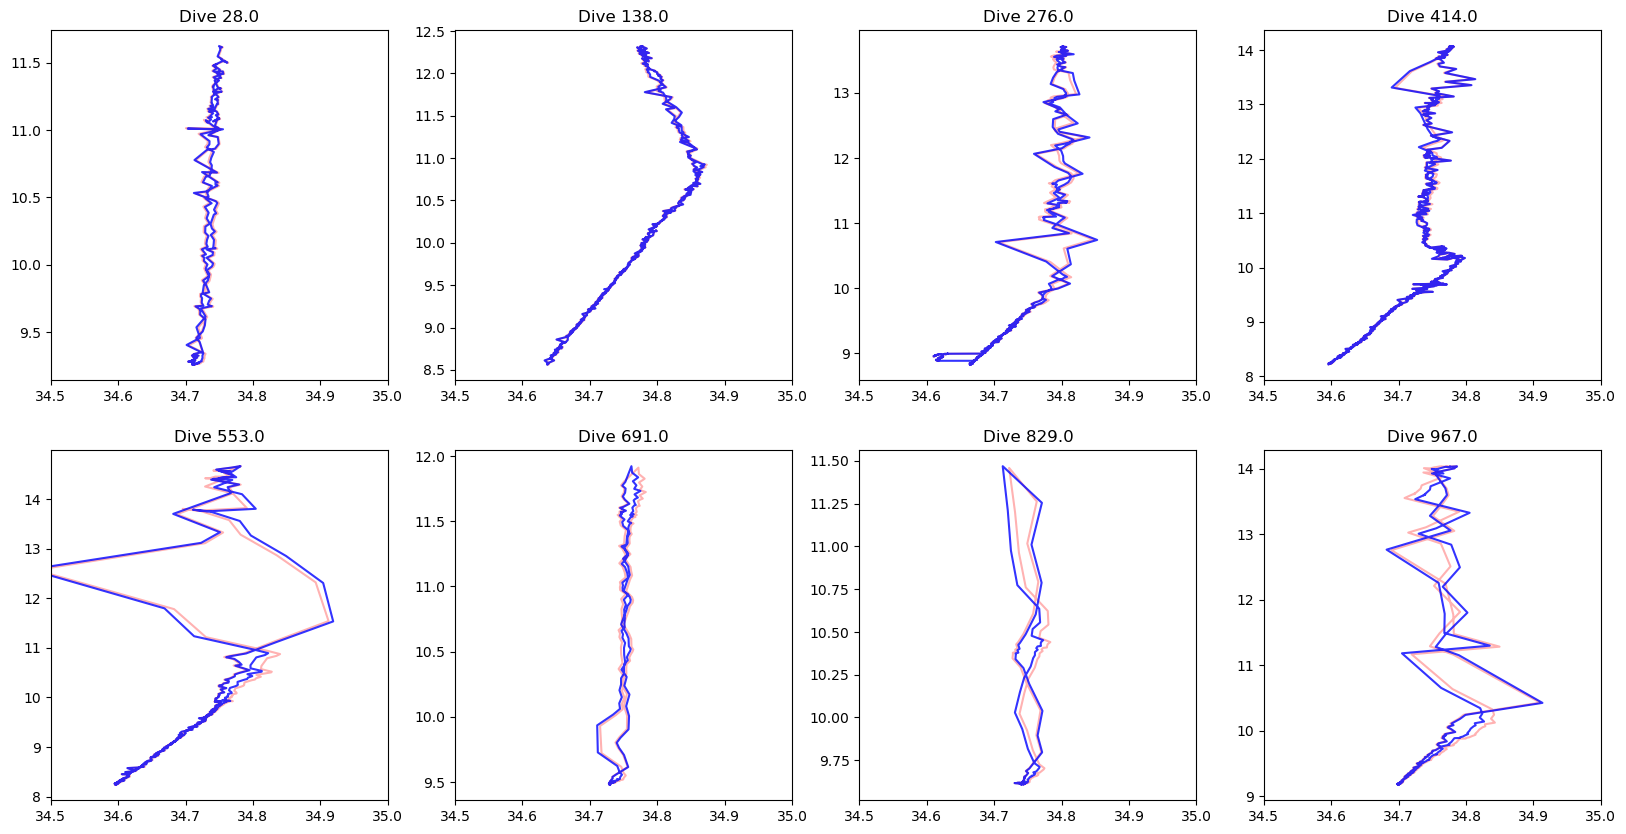

In [42]:
def _verify(data):
    plt.figure(figsize=(20,10))

    dives = data.dive_index.values
    dives = np.unique(dives[np.isfinite(dives)])
    dives = np.round(np.percentile(dives,[1,5,10,15,20,25, 30,35]))
    # xlims = np.nanpercentile(data.salinity.values,[1,99])
    xlims = [34.5,35]
    
    for idx in range(len(dives)):
        plt.subplot(2,int(len(dives)/2),idx+1)
        dn = ((data.dive_index == dives[idx]) &
              (data.pressure > 10) &
              (data.pressure < 200)).compute()

        plt.plot(data.salinity.where(dn, drop=True).values,
                 data.temperature.where(dn, drop=True).values, '-r', alpha=0.3)
        
        plt.plot(data.salinity_corr.where(dn, drop=True).values,
                 data.temperature_corr.where(dn, drop=True).values, '-b', alpha=0.8)

        plt.title('Dive '+str(dives[idx]))
        plt.xlim(xlims)

_verify(data2)